In [ ]:
!pip install datasets -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import dlib
import cv2
import numpy as np

# Загрузка детектора лиц
detector = dlib.get_frontal_face_detector()

In [26]:
# Загрузка модели-предиктора
!wget https://huggingface.co/spaces/asdasdasdasd/Face-forgery-detection/resolve/ccfc24642e0210d4d885bc7b3dbc9a68ed948ad6/shape_predictor_68_face_landmarks.dat
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

--2024-12-19 08:00:27--  https://huggingface.co/spaces/asdasdasdasd/Face-forgery-detection/resolve/ccfc24642e0210d4d885bc7b3dbc9a68ed948ad6/shape_predictor_68_face_landmarks.dat
Resolving huggingface.co (huggingface.co)... 18.160.143.76, 18.160.143.32, 18.160.143.75, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.76|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/fc/8f/fc8fdd1edac6c2dd10eba239245ef331f010fa9491b0003fee03a07be2909850/fbdc2cb80eb9aa7a758672cbfdda32ba6300efe9b6e6c7a299ff7e736b11b92f?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27shape_predictor_68_face_landmarks.dat%3B+filename%3D%22shape_predictor_68_face_landmarks.dat%22%3B&Expires=1734854427&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNDg1NDQyN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9mYy84Zi9mYzhmZGQxZWRhYzZjMmRkMTBlYmEyMzkyNDVlZjMzMWYwMTBmYTk0OTFiMDAwM2ZlZTAzYTA3YmUyOT

In [6]:
from datasets import load_dataset
ds = load_dataset("bitmind/celeb-a-hq_training_faces", "base_transforms")

README.md:   0%|          | 0.00/920 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29412 [00:00<?, ? examples/s]

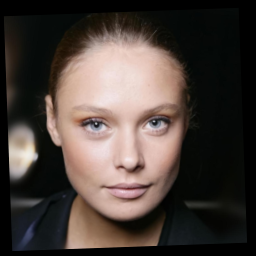

In [19]:
from google.colab.patches import cv2_imshow
import random

random.choice(ds['train'][50:150]['image'])

In [11]:
def get_landmark_points(landmarks, intervals):
    """
    Получение массива координат лицевых ориентиров на основе заданных интервалов.

    Parameters:
    - landmarks: Объект dlib с лицевыми ориентирами.
    - intervals: Строка с интервалами в формате, например, "2-10,30-40".

    Returns:
    - points: numpy массив координат точек.
    """
    points = []

    # Разбиваем строку интервалов на части
    for interval in intervals.split(','):
        start, end = map(int, interval.split('-'))
        # Добавляем точки из указанного интервала
        points.extend([(landmarks.part(i).x, landmarks.part(i).y) for i in range(start, end + 1)])

    return np.array(points, dtype=np.float32)


def get_intervals_from_parts(
        parts_list,
        parts_dict = {
            'контур лица': '0-16',
            'левая бровь': '17-21',
            'правая бровь': '22-26',
            'нос переносица': '27-30',
            'нос крылья': '31-35',
            'левый глаз': '36-41',
            'правый глаз': '42-47',
            'внешние губы': '48-59',
            'внутренние губы': '60-67'
        },
        tips_only=False
    ):
    """
    Получение строки с интервалами точек на основе заданного списка частей лица.

    Parameters:
    - parts_dict: Словарь с названиями частей лица и соответствующими интервалами.
    - parts_list: Список частей лица, для которых нужно получить интервалы.
    - tips_only: Если True, будут выбраны только концы частей лица (начальная и конечная точки).

    Returns:
    - Строка с интервалами, объединенная через запятую.
    """
    intervals = []

    # Проходимся по списку частей лица и извлекаем интервалы из словаря
    for part in parts_list:
        if part in parts_dict:
            start, end = map(int, parts_dict[part].split('-'))
            if tips_only:
                # Добавляем только кончики частей лица (начальную и конечную точки)
                intervals.append(f'{start}-{start}')
                intervals.append(f'{end}-{end}')
            else:
                # Добавляем весь интервал
                intervals.append(parts_dict[part])

    # Объединяем все интервалы в одну строку через запятую
    return ','.join(intervals)

In [21]:
# Загрузка лица-шаблона, по которому будем выравнивать
!gdown 1nAictkvmYxOJGcH2m1byl_y_b6ClbENX  # 128x128
!gdown 1whO37yocxQpsoOudQZLj_GbAus2-Z7Xn  # 256x256

Downloading...
From: https://drive.google.com/uc?id=1nAictkvmYxOJGcH2m1byl_y_b6ClbENX
To: /content/template_face_128x128.png
100% 26.9k/26.9k [00:00<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1whO37yocxQpsoOudQZLj_GbAus2-Z7Xn
To: /content/template_face_256x256.png
100% 77.4k/77.4k [00:00<00:00, 4.34MB/s]


In [22]:
reference_path = '/content/template_face_128x128.png'
reference_img = cv2.imread(reference_path)
reference_faces = detector(reference_img)

def align_face_with_reference(
        img,
        method = "affine"
    ):
    """
    Функция для выравнивания лица по образцу.

    Parameters:
    - image_path: Путь к изображению, которое нужно выровнять.
    - reference_path: Путь к эталонному изображению.
    """
    # Обнаружение лиц на изображении и эталонном изображении
    faces = detector(img)

    # Подразумеваем, что лица найдены на обоих изображениях
    face = faces[0]
    reference_face = reference_faces[0]

    # Получение лицевых ориентиров для обоих изображений
    landmarks = predictor(img, face)
    reference_landmarks = predictor(reference_img, reference_face)

    # Определение опорных точек для глаз, носа и краев губ
    faces_part = get_intervals_from_parts([
        'левый глаз',
        'правый глаз',
        'контур лица',
        'левая бровь',
        'правая бровь',
        'внешние губы',
        'нос переносица'
    ])

    # Получение опорных точек для исходного и эталонного изображения
    src_pts = get_landmark_points(landmarks, faces_part)
    dst_pts = get_landmark_points(reference_landmarks, faces_part)

    # Выбор метода преобразования
    if method == "homography":
        # Гомография: Используется проективное преобразование с использованием RANSAC
        h_matrix, _ = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC)
        aligned_face = cv2.warpPerspective(img, h_matrix, (reference_img.shape[1], reference_img.shape[0]))

    elif method == "affine":
        # Аффинное преобразование: огриничиваемся только поворотами и сдвигами
        affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
        aligned_face = cv2.warpAffine(img, affine_matrix, (reference_img.shape[1], reference_img.shape[0]))

    elif method == "full_affine":
        # Полное аффинное преобразование: включает сжатие / растяжение вдоль осей
        full_affine_matrix, _ = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC)
        aligned_face = cv2.warpAffine(img, full_affine_matrix, (reference_img.shape[1], reference_img.shape[0]))

    elif method == "perspective":
        # Проективное преобразование: Требуется ровно четыре точки
        if len(src_pts) >= 4 and len(dst_pts) >= 4:
            src_pts_perspective = np.float32(src_pts[:4])
            dst_pts_perspective = np.float32(dst_pts[:4])
            perspective_matrix = cv2.getPerspectiveTransform(src_pts_perspective, dst_pts_perspective)
            aligned_face = cv2.warpPerspective(img, perspective_matrix, (reference_img.shape[1], reference_img.shape[0]))
        else:
            raise ValueError("Недостаточно точек для перспективного преобразования, нужно минимум 4.")

    return aligned_face

array([[[179, 209, 250],
        [176, 208, 249],
        [174, 206, 247],
        ...,
        [ 23,  22,  20],
        [ 25,  24,  22],
        [ 29,  28,  26]],

       [[177, 207, 247],
        [175, 207, 248],
        [172, 204, 245],
        ...,
        [ 21,  20,  18],
        [ 27,  26,  24],
        [ 28,  27,  25]],

       [[178, 207, 247],
        [174, 206, 247],
        [171, 203, 244],
        ...,
        [ 18,  17,  15],
        [ 25,  24,  22],
        [ 29,  28,  26]],

       ...,

       [[229, 254, 251],
        [230, 254, 251],
        [231, 253, 251],
        ...,
        [  5,  14,  16],
        [  6,  18,  18],
        [  7,  18,  19]],

       [[226, 254, 251],
        [227, 254, 251],
        [230, 253, 251],
        ...,
        [  5,  13,  15],
        [  5,  15,  16],
        [  7,  17,  19]],

       [[226, 252, 252],
        [226, 252, 252],
        [227, 252, 253],
        ...,
        [  5,  12,  14],
        [  5,  15,  16],
        [  6,  18,  18]]], dtype=uint8)
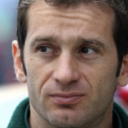

In [23]:
# @title Случайное лицо из датасета
align_face_with_reference(
    np.array(random.choice(ds['train'][0:50]['image']))
)

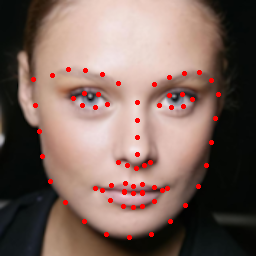

In [28]:
# @title Показать опорные точки на лице (просто визуализация)
import cv2
import dlib
from PIL import Image, ImageDraw
import numpy as np
from google.colab.patches import cv2_imshow


def show_landmarks_on_face(img):
    """
    Функция для отображения изображения с нарисованными лицевыми ориентирами.

    Parameters:
    - image_path: Путь к изображению, на котором нужно показать лицевые ориентиры.
    """

    # Обнаружение лиц на изображении
    faces = detector(img)

    # Проверка, что лицо найдено
    if len(faces) > 0:
        face = faces[0]

        # Получение лицевых ориентиров
        landmarks = predictor(img, face)

        # Преобразуем изображение OpenCV в PIL.Image для рисования
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Создаем объект ImageDraw для рисования на изображении
        draw = ImageDraw.Draw(img_pil)

        # Нарисовать все опорные точки (например, все 68 точек)
        for i in range(68):
            # Получаем координаты точки
            x = landmarks.part(i).x
            y = landmarks.part(i).y

            # Рисуем маленький круг (радиус 2) в каждой опорной точке
            radius = 2
            draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill="red")

        # Преобразование обратно в формат OpenCV и отображение
        img_with_landmarks = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        cv2_imshow(img_with_landmarks)

        # Ожидание нажатия клавиши для закрытия окна
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Лицо не найдено на изображении.")


# Просто визуализация ключевых точек
show_landmarks_on_face(cv2.imread('/content/template_face_256x256.png'))

In [44]:
# @title Процессинг дополнительного датасета
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
import cv2

# Создаём папку для изображений
output_path = '/content/faces/'
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs(output_path, exist_ok=True)

# Создание выходной директории, если она не существует
os.makedirs(output_path, exist_ok=True)

for idx in tqdm(range(len(ds['train'][:100]['image']))):
    try:
        # Достаём изображение по индексу и преобразование в greyscale
        face = ds['train'][int(idx)]['image'].convert('RGB')

        # Вызов функции для выравнивания лица
        aligned_face = align_face_with_reference(np.array(face))
        aligned_face_rgb = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)

        # Проверка, что изображение выровнено корректно
        if aligned_face is not None:
            # Сохранение результата обработки
            output_image_path = os.path.join(output_path, "image_" + str(idx) + '.jpg')
            cv2.imwrite(output_image_path, aligned_face_rgb)

    except IndexError:
        print(f"Лицо не найдено на изображении: {idx}")

  0%|          | 0/100 [00:00<?, ?it/s]

Лицо не найдено на изображении: 16
Лицо не найдено на изображении: 25


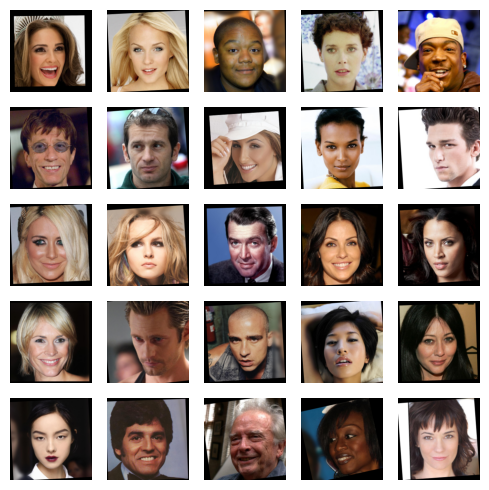

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def show_dataset_images(images, grid_size=(5, 5)):
    """
    Функция для отображения сетки изображений из датасета.

    Parameters:
    - images: Изображения из датасета.
    - grid_size: Размер сетки в формате (строки, столбцы).
    """
    n_images = grid_size[0] * grid_size[1]

    # Проверка, достаточно ли изображений
    if len(images) < n_images:
        print(f"Недостаточно изображений для создания сетки {grid_size}.")
        n_images = len(images)

    # Создание фигуры для отображения
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1], grid_size[0]))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_images:
            # Получение изображения и преобразование в RGB (если требуется)
            img = np.array(images[i])
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


# Рисуем исходные изображения
show_dataset_images(ds['train'][:100]['image'], grid_size=(5, 5))

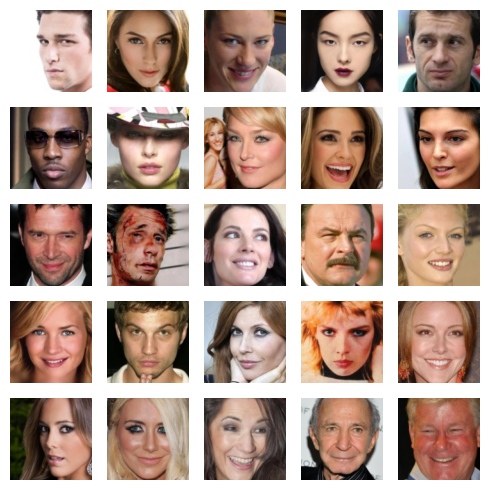

In [64]:
import matplotlib.pyplot as plt
import random
import os

def show_images_grid(folder_path, grid_size=(5, 5)):
    """
    Функция для отображения сетки изображений из указанной папки.

    Parameters:
    - folder_path: Путь к папке с изображениями.
    - grid_size: Размер сетки в формате (строки, столбцы).
    """
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    random.shuffle(image_files)
    n_images = grid_size[0] * grid_size[1]

    # Проверка, достаточно ли изображений
    if len(image_files) < n_images:
        print(f"Недостаточно изображений для создания сетки {grid_size}.")
        n_images = len(image_files)

    # Создание фигуры для отображения
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1], grid_size[0]))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_images:
            img = cv2.imread(image_files[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


# Показываем выровненные лица
output_folder = '/content/faces/'
show_images_grid(output_folder, grid_size=(5, 5))